In [13]:
import cv2
import imutils
import numpy as np
import time
from matplotlib import pyplot as plt
from keras.models import load_model
import PIL
from PIL import ImageOps

# Reference: https://www.pyimagesearch.com/2015/09/14/ball-tracking-with-opencv/

**TODO**: 
- Get rid of side borders
    - Start looking at pixels on borders, how many ever pixels it takes to change to white, crop that much off all sides
    - Could possibly use same width to get rid of inner thick borders? Can you crop a mid section out?
- Generate new pictures
    - Thicker borders
    - Borders that aren't flat on the upper edge (have a white space gap)
    - Maybe make pictures slightly bigger (150px?)

In [14]:
def showImg(image, title="Picture"):
#     gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    plt.imshow(image)
    plt.title(title)
    plt.show()

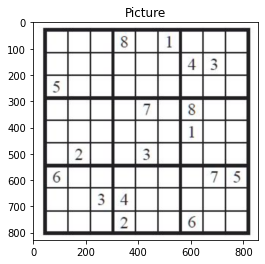

In [52]:
samplePath = "/Users/patrickbell/Documents/sodukuAI/puzzleDetector/sample1.png"
img = cv2.imread(samplePath)

showImg(img)

In [39]:
# AUTOMATICALLY FIND COLOR

blackLower = (0,0,0)
blackUpper = (200,200,200)

threshhold = 0.4

for i in range(img.shape[0]):
    color = img[i][i]
    if color[0] < 200 and color[1] < 200 and color[2] < 200:
        blackLower = (color[0]-color[0]*threshhold,color[1]-color[1]*threshhold,color[2]-color[2]*threshhold)
        blackUpper = (color[0]+color[0]*threshhold,color[1]+color[1]*threshhold,color[2]+color[2]*threshhold)
        break
        
print(blackLower,blackUpper)

(91.19999999999999, 90.6, 91.19999999999999) (212.8, 211.4, 212.8)


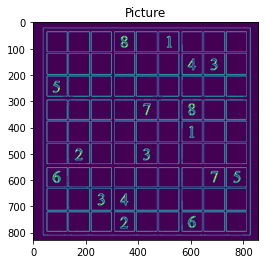

In [40]:
# Filtering by color

mask = cv2.inRange(img, blackLower, blackUpper)
showImg(mask)

[[ 38 809]
 [ 38  21]
 [825  21]
 [825 809]]


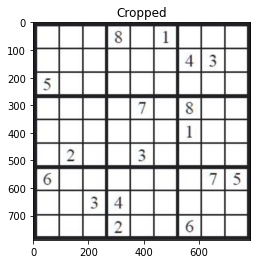

In [41]:
# Get contours

cnts = cv2.findContours(mask.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnts = imutils.grab_contours(cnts)
cnts = cv2.findContours(mask.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnts = imutils.grab_contours(cnts)
cnt = max(cnts, key=cv2.contourArea)

# Get rectangle of masked image
rect = cv2.minAreaRect(cnt)
box = cv2.boxPoints(rect)
box = np.int0(box)
print(box)

# Assign coordinates of rectangle
topLeftCornerX = box[1][0]
topLeftCornerY = box[1][1]
bottomRightCornerX = box[3][0]
bottomRightCornerY = box[3][1]

# The image of just the grid
croppedImg = img[topLeftCornerY:bottomRightCornerY, topLeftCornerX:bottomRightCornerX]
showImg(croppedImg, "Cropped")

In [42]:
# Get 9 sub grids

subGrids = [
    [[],[],[]],
    [[],[],[]],
    [[],[],[]]
]

height, width, colorChannels = croppedImg.shape

# grid1 = img[y:ymax, x:xmax]
# grid1 = croppedImg[0:int(height/3), 0:int(width/3)]

# Loops through each grid size and adds the grid to the grids array
xInc = int(height/3)
yInc = int(width/3)
for i in range(3):
    for j in range(3):
        subGrids[i][j] = croppedImg[yInc*i:yInc*i+yInc, xInc*j:xInc*j+xInc]

# grid = subGrids[1][2]
# showImg(grid)

In [43]:
# Create cells

# Ex cells[subGridRow][subGridColumn][row][column]
cells = []

for subGridRow in range(3):
    cells.append([])
    for subGridColumn in range(3):
        cells[subGridRow].append([])
        for row in range(3):
            cells[subGridRow][subGridColumn].append([])
            for column in range(3):
                cells[subGridRow][subGridColumn][row].append(None)
                
                
for subGridRow in range(3):
    for subGridColumn in range(3):
        subGridImg = subGrids[subGridRow][subGridColumn]
        subGridImgHeight, subGridImgWidth, subGridImgColorChannels = subGridImg.shape
        xInc = int(subGridImgHeight/3)
        yInc = int(subGridImgWidth/3)
        for i in range(3):
            for j in range(3):
                cells[subGridRow][subGridColumn][i][j] = subGridImg[yInc*i:yInc*i+yInc, xInc*j:xInc*j+xInc]



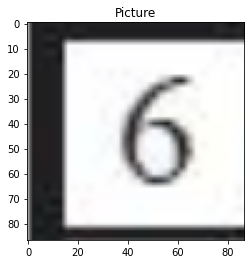

In [44]:
cell = cells[2][0][0][0]
showImg(cell)

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
import pathlib

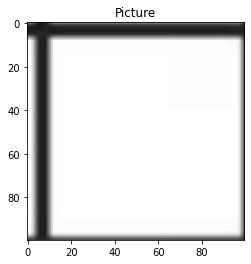

This image most likely belongs to blank with a 99.81 percent confidence.


In [54]:
# Loads the model and class names

new_model = tf.keras.models.load_model('/Users/patrickbell/Documents/sodukuAI/digitClassifier/wholeModelSaveWith7Epochs')
class_names = ['1', '2', '3', '4', '5', '6', '7', '8', '9', 'blank']
# Pick cell and save/load it

cell = cells[1][0][1][2]

imagePath = "/Users/patrickbell/Documents/sodukuAI/digitClassifier/testImg.png"
resizedCell = cv2.resize(cell, (100,100), interpolation = cv2.INTER_AREA)
img = PIL.Image.fromarray(resizedCell)
image = ImageOps.grayscale(img)
image.save(imagePath)


img = keras.preprocessing.image.load_img(
    imagePath, target_size=(100, 100)
)

img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch
showImg(img)

# Predict

predictions = new_model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)
# showImg(img)

In [58]:
new_model = tf.keras.models.load_model('/Users/patrickbell/Documents/sodukuAI/digitClassifier/wholeModelSave')
class_names = ['1', '2', '3', '4', '5', '6', '7', '8', '9', 'blank']

def convertImageToNumber(model, img):
    imagePath = "/Users/patrickbell/Documents/sodukuAI/digitClassifier/testImg.png"
    resizedCell = cv2.resize(img, (100,100), interpolation = cv2.INTER_AREA)
    img = PIL.Image.fromarray(resizedCell)
    image = ImageOps.grayscale(img)
    image.save(imagePath)
    img = keras.preprocessing.image.load_img(
        imagePath, target_size=(100, 100)
    )

    img_array = keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0) # Create a batch
    predictions = model.predict(img_array)
    score = tf.nn.softmax(predictions[0])
    if (np.max(score)) < 0.7:
        print(class_names[np.argmax(score)],np.max(score),"\n",score)
        showImg(img)
    prediction = class_names[np.argmax(score)]
    return prediction
    

5 0.6981855 
 tf.Tensor(
[3.7153302e-05 1.6107628e-04 4.3827207e-03 1.9736591e-04 6.9818550e-01
 2.5664401e-01 2.7078737e-02 1.2763267e-02 5.4661580e-04 3.6117744e-06], shape=(10,), dtype=float32)


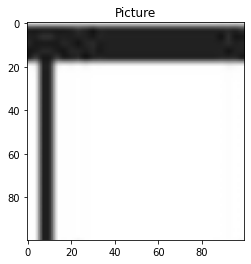

6 0.5209985 
 tf.Tensor(
[5.5798038e-05 6.5793510e-04 2.1586714e-03 2.4994940e-04 4.4500208e-01
 5.2099848e-01 1.5204628e-02 6.3426942e-03 2.2411093e-03 7.0887348e-03], shape=(10,), dtype=float32)


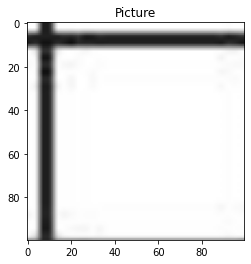

5 0.5058339 
 tf.Tensor(
[4.1407031e-05 1.1110631e-03 4.3993862e-03 4.8705240e-04 5.0583392e-01
 4.5277971e-01 7.1381917e-03 6.5208543e-03 3.2998594e-03 1.8388459e-02], shape=(10,), dtype=float32)


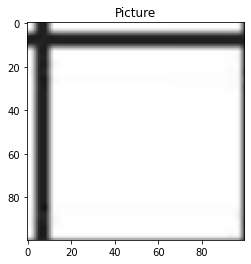

8 0.5442662 
 tf.Tensor(
[5.8437882e-10 2.3952024e-08 1.4982802e-01 3.9547558e-07 2.9987001e-01
 6.0316925e-03 8.1401714e-07 5.4426622e-01 2.8605948e-06 2.2423613e-18], shape=(10,), dtype=float32)


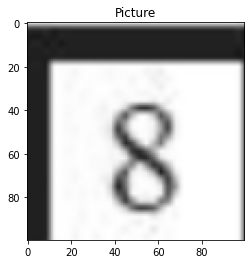

7 0.5180673 
 tf.Tensor(
[4.4335742e-04 7.5995191e-03 7.6189023e-03 1.7876500e-03 4.3987763e-01
 1.8075582e-02 5.1806730e-01 1.7008039e-03 7.4021303e-04 4.0890495e-03], shape=(10,), dtype=float32)


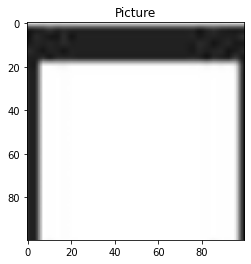

5 0.6132768 
 tf.Tensor(
[1.2613957e-01 2.4118785e-02 2.5977550e-02 1.5949028e-03 6.1327678e-01
 6.2264814e-03 1.9401941e-01 2.9579862e-03 5.6465627e-03 4.2018288e-05], shape=(10,), dtype=float32)


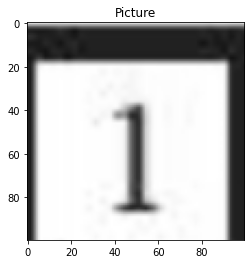

5 0.45453632 
 tf.Tensor(
[3.6023088e-05 4.6588392e-03 4.0467568e-03 7.2795257e-04 4.5453632e-01
 1.0043533e-02 3.8787466e-01 5.5288896e-04 3.5823582e-04 1.3716474e-01], shape=(10,), dtype=float32)


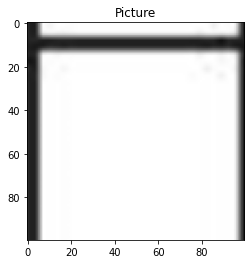

5 0.4889313 
 tf.Tensor(
[5.8176309e-05 4.7269030e-03 3.5196119e-03 4.4368758e-04 4.8893130e-01
 6.3837809e-03 4.6936306e-01 6.5382349e-04 3.4493775e-04 2.5574801e-02], shape=(10,), dtype=float32)


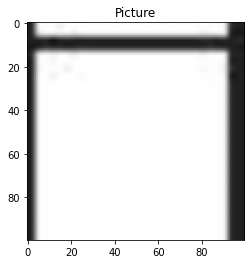

blank 0.5004028 
 tf.Tensor(
[2.0870626e-04 7.4865036e-03 8.0550769e-03 1.9809988e-03 3.5031939e-01
 2.4859192e-02 1.0211797e-01 2.2380988e-03 2.3312406e-03 5.0040281e-01], shape=(10,), dtype=float32)


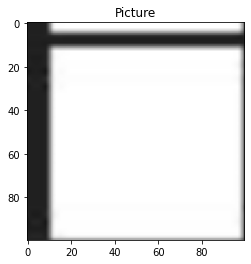

5 0.4797891 
 tf.Tensor(
[0.00085922 0.00886738 0.01044085 0.00224333 0.4797891  0.02390971
 0.46630308 0.0033594  0.001269   0.00295904], shape=(10,), dtype=float32)


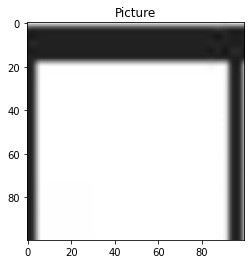

5 0.6155698 
 tf.Tensor(
[0.00119383 0.0091714  0.01861203 0.00146544 0.6155698  0.0204119
 0.3206491  0.0071095  0.00281937 0.00299767], shape=(10,), dtype=float32)


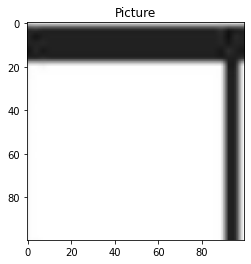

5 0.6146032 
 tf.Tensor(
[0.00072349 0.00711071 0.02369021 0.00080016 0.6146032  0.00982096
 0.3226737  0.01565665 0.00408888 0.00083199], shape=(10,), dtype=float32)


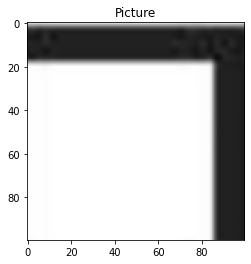

5 0.6073826 
 tf.Tensor(
[1.8188542e-03 1.6224803e-02 8.8692456e-03 1.4679187e-03 6.0738260e-01
 4.3791303e-04 3.6235827e-01 3.9560109e-04 1.0382611e-03 6.6381817e-06], shape=(10,), dtype=float32)


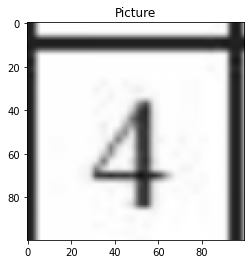

5 0.5627746 
 tf.Tensor(
[3.3727542e-07 6.3715421e-04 4.2466968e-01 1.5998411e-08 5.6277460e-01
 2.8826721e-09 1.1915159e-02 1.3219155e-06 1.7023516e-06 8.5234104e-09], shape=(10,), dtype=float32)


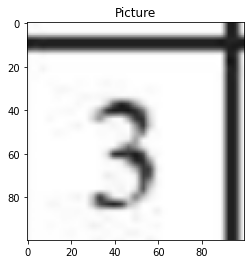

7 0.5345834 
 tf.Tensor(
[3.0623829e-05 1.6554233e-03 6.2792674e-03 1.2738287e-04 4.4024339e-01
 1.4461811e-03 5.3458339e-01 1.7697068e-03 4.2544719e-04 1.3439193e-02], shape=(10,), dtype=float32)


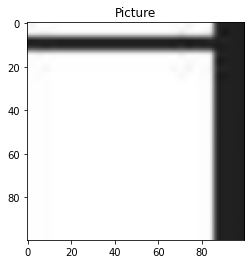

blank 0.6039404 
 tf.Tensor(
[1.1267617e-04 1.6128292e-03 7.8012007e-03 3.5150396e-04 2.1821871e-01
 3.3224991e-03 1.6026567e-01 3.0589518e-03 1.3155666e-03 6.0394043e-01], shape=(10,), dtype=float32)


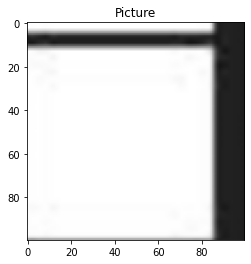

5 0.4443679 
 tf.Tensor(
[0.00183331 0.01365516 0.0521711  0.01279258 0.4443679  0.24376036
 0.09314813 0.04404832 0.01007208 0.08415116], shape=(10,), dtype=float32)


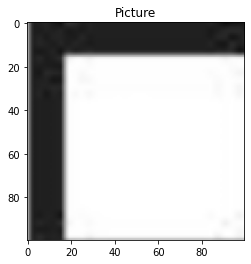

6 0.68752366 
 tf.Tensor(
[3.15569108e-04 6.43793785e-04 1.01243239e-02 8.61005799e-04
 2.33097598e-01 6.87523663e-01 1.43005205e-02 4.74819690e-02
 5.24338149e-03 4.08166496e-04], shape=(10,), dtype=float32)


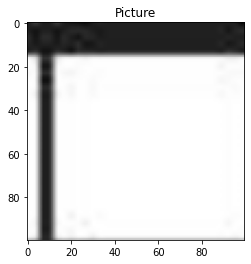

6 0.60904145 
 tf.Tensor(
[3.4628130e-04 1.7767694e-03 1.7903540e-02 1.7608220e-03 2.9834461e-01
 6.0904145e-01 1.1133425e-02 4.9667977e-02 8.7322313e-03 1.2929571e-03], shape=(10,), dtype=float32)


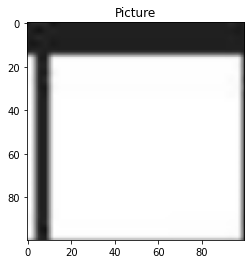

blank 0.47276425 
 tf.Tensor(
[0.0127035  0.01288605 0.01357215 0.01035905 0.05566095 0.30543873
 0.01014404 0.04386595 0.06260531 0.47276425], shape=(10,), dtype=float32)


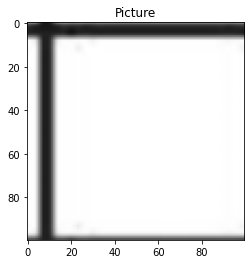

blank 0.6237704 
 tf.Tensor(
[0.00611719 0.02280807 0.02336869 0.01163383 0.05256366 0.16970995
 0.00523893 0.03081175 0.05397754 0.6237704 ], shape=(10,), dtype=float32)


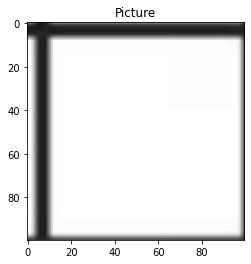

blank 0.54881907 
 tf.Tensor(
[0.00341331 0.01479623 0.01808736 0.01192053 0.03184555 0.2788182
 0.00432178 0.03939419 0.04858381 0.54881907], shape=(10,), dtype=float32)


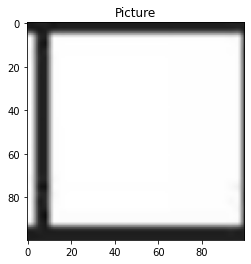

7 0.3229751 
 tf.Tensor(
[0.00563776 0.04535022 0.0465548  0.02503408 0.26208884 0.11778479
 0.3229751  0.03178849 0.0120918  0.1306941 ], shape=(10,), dtype=float32)


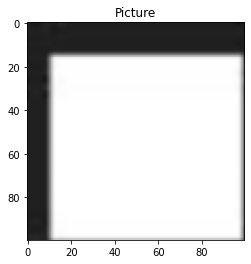

7 0.33421448 
 tf.Tensor(
[0.0048964  0.03617701 0.04199925 0.02275346 0.1696103  0.05911001
 0.33421448 0.02537855 0.009966   0.2958946 ], shape=(10,), dtype=float32)


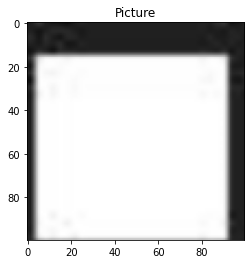

blank 0.42565167 
 tf.Tensor(
[0.00756405 0.01914714 0.0356981  0.01281461 0.1943423  0.04581828
 0.22049744 0.02467902 0.01378739 0.42565167], shape=(10,), dtype=float32)


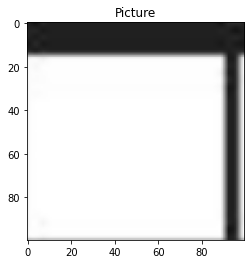

5 0.34061566 
 tf.Tensor(
[0.00399592 0.01052837 0.06057945 0.00589583 0.34061566 0.02429401
 0.33065587 0.04970182 0.02013057 0.15360257], shape=(10,), dtype=float32)


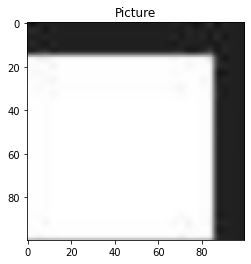

6 0.54462385 
 tf.Tensor(
[0.00606511 0.00847899 0.01204565 0.00552429 0.05755848 0.54462385
 0.01293693 0.05345179 0.05214259 0.2471723 ], shape=(10,), dtype=float32)


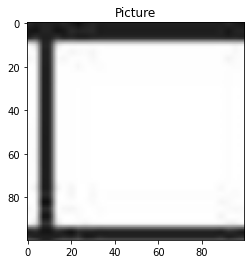

6 0.3919339 
 tf.Tensor(
[0.00383504 0.01833112 0.0244951  0.00895688 0.07057892 0.3919339
 0.00843913 0.04934482 0.05553684 0.36854836], shape=(10,), dtype=float32)


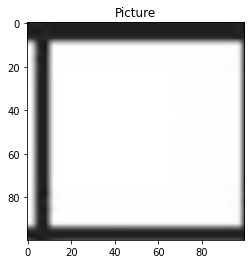

blank 0.6388677 
 tf.Tensor(
[0.00960084 0.00890409 0.00831345 0.01286814 0.03246493 0.19953287
 0.00511291 0.02619382 0.05814125 0.6388677 ], shape=(10,), dtype=float32)


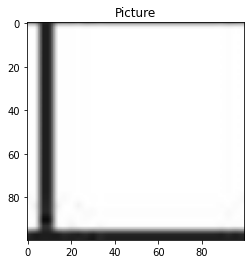

blank 0.6240667 
 tf.Tensor(
[0.04607748 0.05106447 0.06291974 0.03663352 0.05063    0.03667822
 0.02225931 0.03201859 0.03765199 0.6240667 ], shape=(10,), dtype=float32)


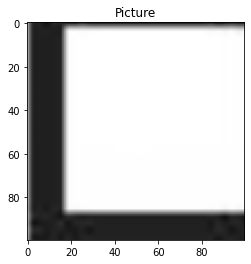

6 0.33797166 
 tf.Tensor(
[0.04156179 0.03542059 0.0372284  0.01830762 0.10988866 0.33797166
 0.01891349 0.08434544 0.18938243 0.12697992], shape=(10,), dtype=float32)


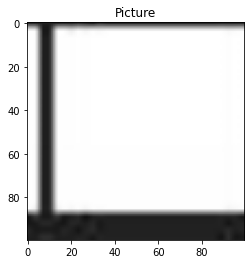

blank 0.23849814 
 tf.Tensor(
[0.03321623 0.06531709 0.06034981 0.02243343 0.12102795 0.22607921
 0.01660516 0.06340774 0.15306528 0.23849814], shape=(10,), dtype=float32)


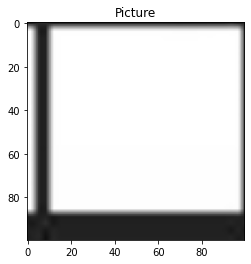

In [59]:
# Recreates all the cells

numberedCells = copy.deepcopy(cells)

for subGridRow in range(3):
    for subGridColumn in range(3):
        for i in range(3):
            for j in range(3):
                numberedCells[subGridRow][subGridColumn][i][j] = convertImageToNumber(new_model, cells[subGridRow][subGridColumn][i][j])

4


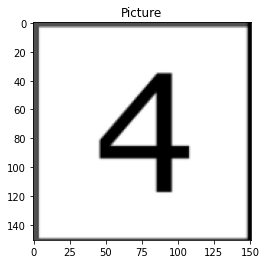

In [37]:
print(numberedCells[1][0][1][2])
showImg(cells[1][0][1][2])


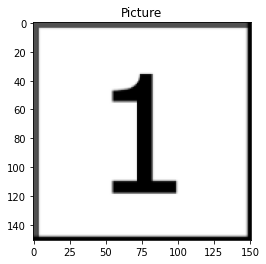

Predicted: 1


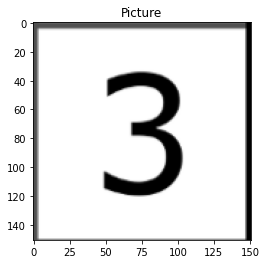

Predicted: 3


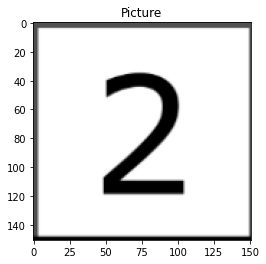

Predicted: 2


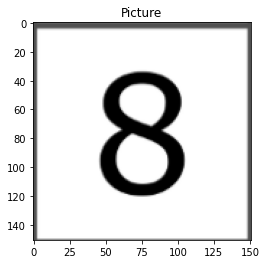

Predicted: 8


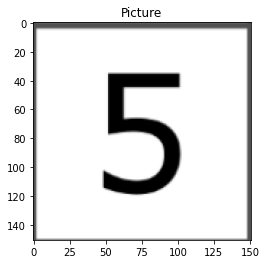

Predicted: 5


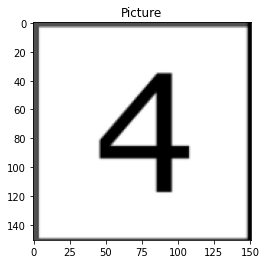

Predicted: 4


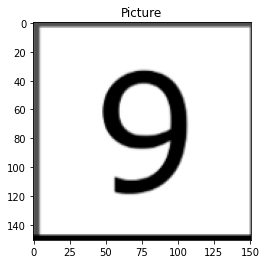

Predicted: 9


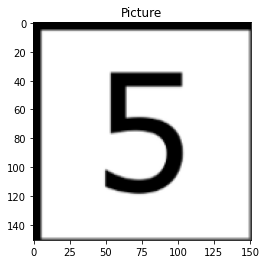

Predicted: 5


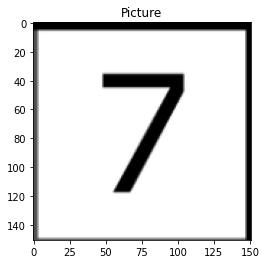

Predicted: 7


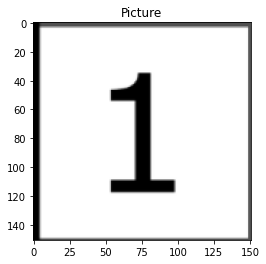

Predicted: 1


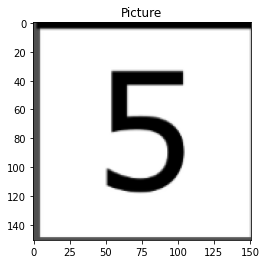

Predicted: 5


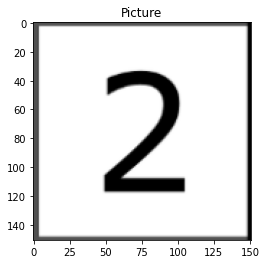

Predicted: 2


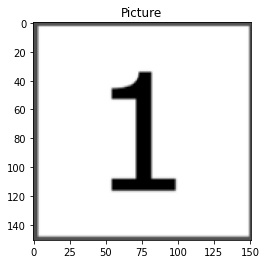

Predicted: 1


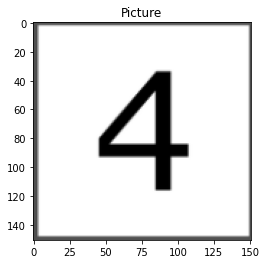

Predicted: 4


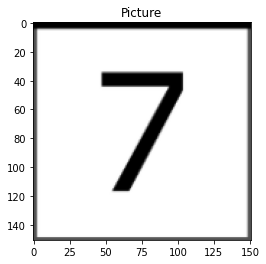

Predicted: 7


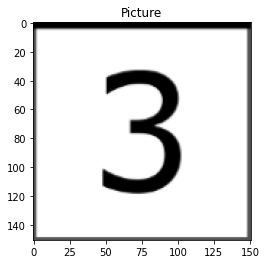

Predicted: 3


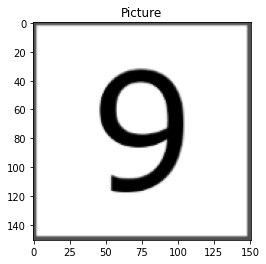

Predicted: 9


In [27]:
# Check results

def showComparison(num1,num2,num3,num4):
    if numberedCells[num1][num2][num3][num4] != "blank":
        showImg(cells[num1][num2][num3][num4])
        print("Predicted: " + str(numberedCells[num1][num2][num3][num4]))


for subGridRow in range(3):
    for subGridColumn in range(3):
        for i in range(3):
            for j in range(3):
                showComparison(subGridRow,subGridColumn,i,j)
                time.sleep(0.5)


In [25]:
import copy